# LoC image analysis

This notebook is designed to assess the feasability of segmenting the basal and apical sides of the coculture, with different cell sizes, using the same segmentation run through.

In [8]:
import os
import glob
import enum
from octopusheavy import DaskOctopusHeavyLoader
import napari
from skimage.io import imshow,  imsave, imread
import napari
import btrack
from tqdm.auto import tqdm
import dask.array as da

# Loading images

Define root path and individual experiment IDs

In [1]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'

In [3]:
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

In [4]:
expt_ID = expt_IDs[0]

In [6]:
images = DaskOctopusHeavyLoader(os.path.join(root_path, expt_ID))

In [7]:
images.channels

[<Channels.CH1: 1>,
 <Channels.CH2: 2>,
 <Channels.CH3: 3>,
 <Channels.CH4: 4>,
 <Channels.MASK1: 99>]

In [11]:
import enum
@enum.unique
class Channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 1
    SPC = 2
    PDPN = 3
    ZO1 = 4
    MASKS = 99

# Segmentation testing

In [19]:
!nvcc --version
!nvidia-smi

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16,12), dpi=80)

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Wed Dec  7 11:26:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   35C    P8    31W / 300W |  12741MiB / 49140MiB |      4%      Default |
|                               |                      |                  N/A |
+

<Figure size 1280x960 with 0 Axes>

### Assess sample  image to find apical diameter

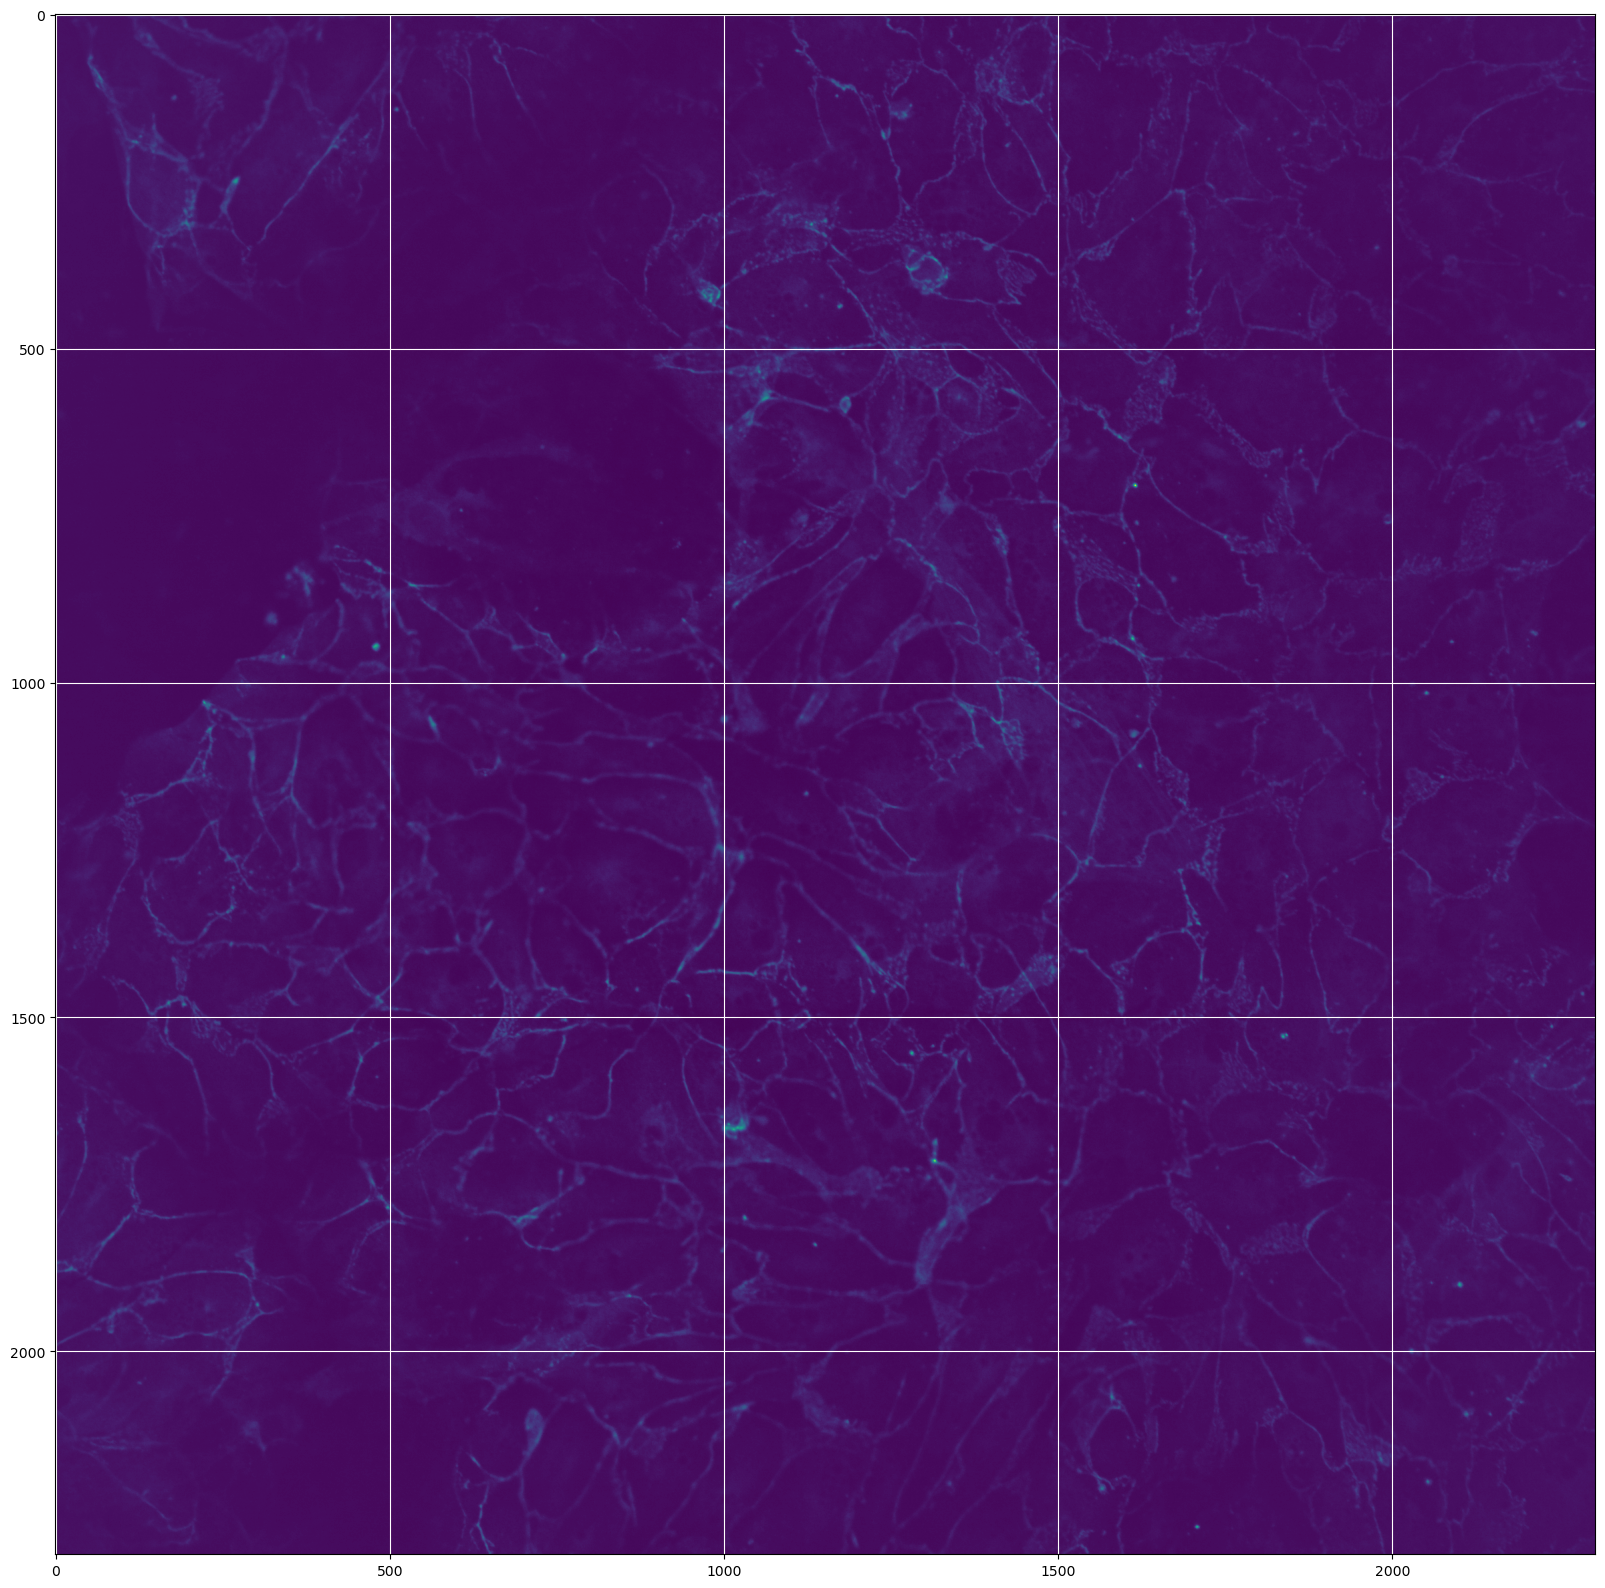

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(images['CH4'][40].compute())
plt.grid(color = 'white')

# could i possibly estimate the  basal-apical transition from the number of masks in each image

In [57]:
from skimage.measure import regionprops
import numpy as np

In [116]:
total_area_count = []
mean_area_count = []
mask_count = []
area_count = []
for mask in masks:
    ### measure number of masks in each image
    props = regionprops(mask)
    mask_count.append(len(props))
    area_count.append([prop.area for prop in props])
    total_area_count.append(np.sum([prop.area for prop in props]))
    mean_area_count.append(np.mean([prop.area for prop in props]))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


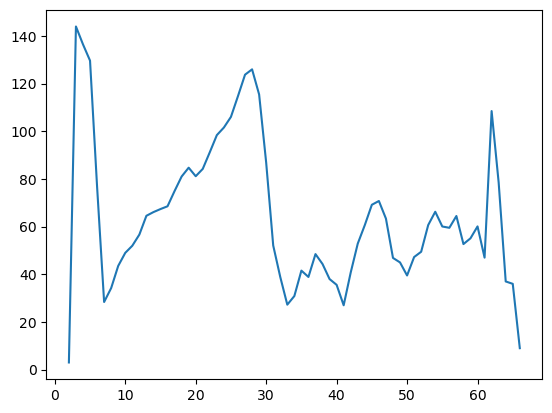

In [117]:
plt.plot(mean_area_count)

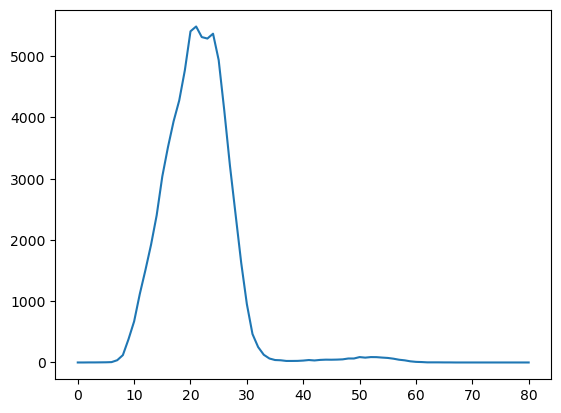

In [59]:
plt.plot(mask_count)

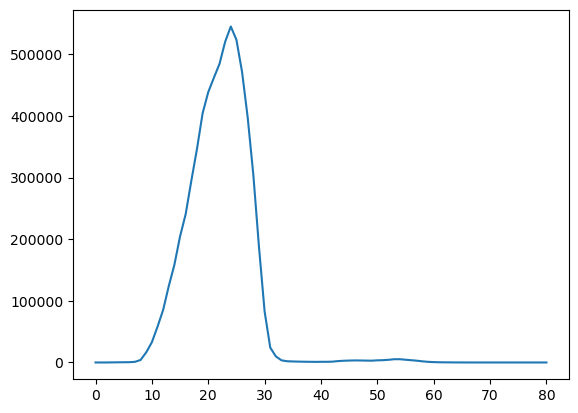

In [60]:
plt.plot(total_area_count)

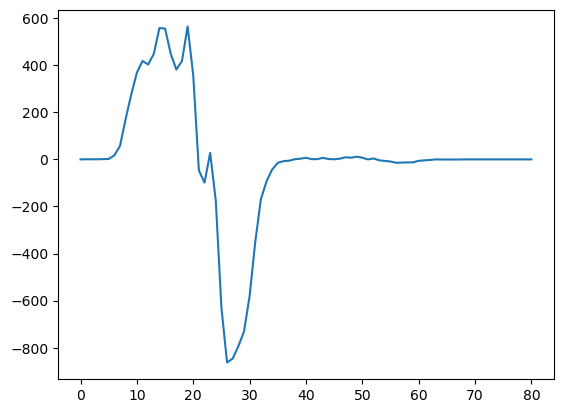

In [68]:
plt.plot(np.gradient(mask_count))


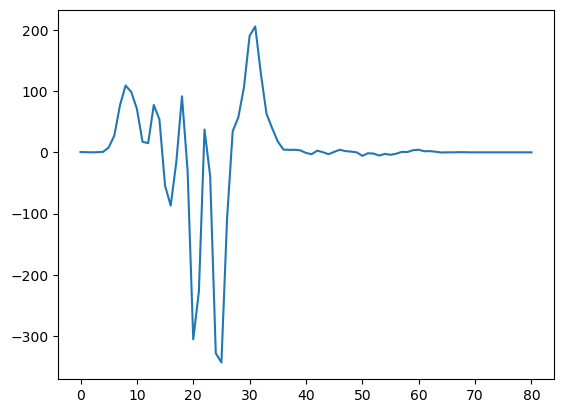

In [123]:
plt.plot(np.gradient(np.gradient(mask_count)))

#### automated way, take the maximum of the double derivative of the mask count (ie when the number of masks suddenly stops decreasing) and use that as the timepoint of apical basal transition

In [129]:
[n for n, i in enumerate(np.gradient(np.gradient(mask_count))) if i == max(np.gradient(np.gradient(mask_count)))][0]

31

### The below function calculates the minimum of the gradient of the number of 

In [96]:
[n for n, i in enumerate(np.gradient(total_area_count)) if i == min(np.gradient(total_area_count))][0]

29

In [98]:
[n for n, i in enumerate(np.gradient(mask_count)) if i == min(np.gradient(mask_count))][0]

26

In [85]:
np.gradient(mask_count) < 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [127]:
[i for i, val in enumerate((mask_count)) if val < 1]

[0, 1, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]

In [137]:
252/np.max(mask_count)

0.04594348222424795

In [114]:
for n, i in enumerate(mask_count):
    print(n, i)

0 0
1 0
2 1
3 1
4 2
5 3
6 6
7 37
8 120
9 379
10 671
11 1116
12 1507
13 1922
14 2403
15 3038
16 3514
17 3936
18 4277
19 4771
20 5406
21 5485
22 5312
23 5288
24 5367
25 4937
26 4108
27 3212
28 2416
29 1625
30 953
31 464
32 252
33 126
34 65
35 40
36 36
37 25
38 25
39 26
40 31
41 40
42 33
43 42
44 46
45 45
46 47
47 51
48 65
49 65
50 88
51 79
52 88
53 87
54 80
55 74
56 62
57 45
58 35
59 19
60 10
61 7
62 2
63 2
64 2
65 1
66 1
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0


In [101]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
basal_mask_stack, apical_mask_stack = [], []
### iterate over frames
for i, (image, fn) in tqdm(enumerate(zip(images['CH4'], images.files('CH4'))), total = len(images['CH4'])):
    ### testing purposes
#     apical_masks, flows, styles, diams = model.eval(image, 
#                                                         diameter=None, 
#                                                         flow_threshold=None, 
#                                                         channels=channels, 
#                                                         #progress = True
#                                                        )
#     apical_mask_stack.append(apical_masks)
#     ### read the number of masks by measuring the max label value (quicker than regionprops)
#     n_labels = np.max(apical_masks)
#     n_labels_list.append(n_labels)
    
#     if i < 35:
#         ### run segmentation
#         apical_masks, flows, styles, diams = model.eval(image, 
#                                                         diameter=None, 
#                                                         flow_threshold=None, 
#                                                         channels=channels, 
#                                                         #progress = True
#                                                        )
#         apical_mask_stack.append(apical_masks)
#     ### rename and save out
# #     fn = fn.replace('c004', 'c099')
# #     imsave(fn, masks, check_contrast=False)
#     else:
#         basal_masks, flows, styles, diams = model.eval(image, 
#                                                        diameter=None, 
#                                                        flow_threshold=None, 
#                                                        channels=channels, 
#                                                        #progress = True, 
#                                                        min_size=2000
#                                                       )

#         basal_mask_stack.append(basal_masks)
    
# basal_masks = da.stack(basal_mask_stack, axis = 0)
# apical_masks = da.stack(apical_mask_stack, axis = 0)

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


CPU times: user 13.9 s, sys: 13.4 s, total: 27.3 s
Wall time: 9.53 s


In [130]:
apical_basal_transition = [n for n, i in enumerate(np.gradient(np.gradient(mask_count))) if i == max(np.gradient(np.gradient(mask_count)))][0]

In [131]:
apical_basal_transition

31

In [106]:
%%timeit
len(regionprops(apical_masks))

21.7 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%%timeit
np.max((apical_masks))

3.64 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
np.max((apical_masks)), len(regionprops(apical_masks))

(216, 216)

In [38]:
v = napari.Viewer()

v.add_image(images['CH4'][38:42])
v.add_labels(masks)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


<Labels layer 'masks' at 0x7fabb909f640>

## Testing other params of cellpose

In [39]:
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=None, channel_axis=None, z_axis=None, invert=False, normalize=True, diameter=30.0, do_3D=False, anisotropy=None, net_avg=False, augment=False, tile=True, tile_overlap=0.1, resample=True, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, min_size=15, stitch_threshold=0.0, rescale=None, progress=None, model_loaded=False) method of cellpose.models.Cellpose instance
    run cellpose and get masks
    
    Parameters
    ----------
    x: list or array of images
        can be list of 2D/3D images, or array of 2D/3D images, or 4D image array
    
    batch_size: int (optional, default 8)
        number of 224x224 patches to run simultaneously on the GPU
        (can make smaller or bigger depending on GPU memory usage)
    
    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
        First element of list is the channel to segment (0=g

In [40]:
images['CH4']

dask.array<stack, shape=(81, 2304, 2304), dtype=float32, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

In [42]:
masks, flows, styles, diams = model.eval(images['CH4'], 
                                         diameter=100, 
                                         flow_threshold=None, 
                                         channels=channels, 
                                         progress = True, 
                                         do_3D=True)


SystemError: CPUDispatcher(<function steps3D at 0x7fadee3274c0>) returned a result with an error set

In [ ]:
masks